# Three-particle problem

In [1]:
%reload_ext lab_black

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import complex_ode

from quantum_systems import ODQD, GeneralOrbitalSystem
from quantum_systems.time_evolution_operators import TimeEvolutionOperator

from configuration_interaction import CISDT, TDCISDT
from configuration_interaction.ci_helper import state_printer

from gauss_integrator import GaussIntegrator

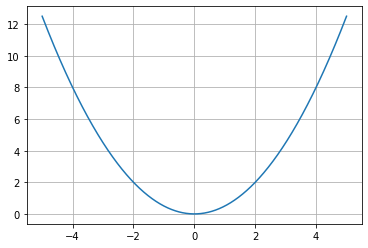

In [129]:
omega = 1

n = 3
l = 3
soft_coulomb = 1
kappa = 1

potential = ODQD.HOPotential(omega=omega)

grid_length = 5
num_grid_points = 2001
grid = np.linspace(-grid_length, grid_length, num_grid_points)

plt.plot(grid, potential(grid))
plt.grid()

plt.show()

In [130]:
system = GeneralOrbitalSystem(
    n,
    ODQD(
        l,
        grid_length,
        num_grid_points,
        a=soft_coulomb,
        alpha=kappa,
        potential=potential,
    ),
)

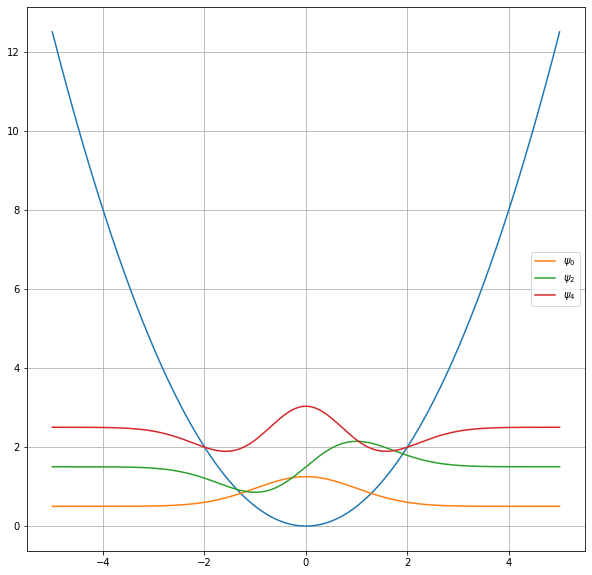

In [131]:
fig = plt.figure(figsize=(10, 10))

plt.plot(grid, potential(grid))

for i in range(0, system.l, 2):
    plt.plot(
        system.grid,
        system.spf[i].real + system.h[i, i].real,
        "-" if i % 2 == 0 else "--",
        label=fr"$\psi_{i}$",
    )

plt.grid()
plt.legend()
plt.show()

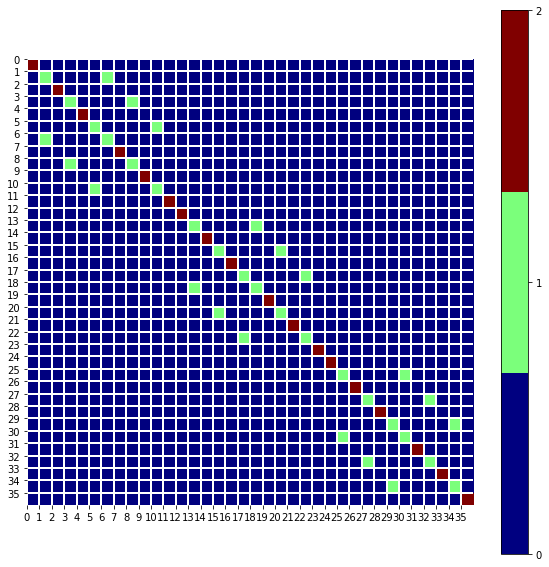

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))

spin_2 = system.spin_2.reshape(int(system.l ** 2), int(system.l ** 2)).real
extent = (0, spin_2.shape[1], spin_2.shape[0], 0)

cmap = plt.get_cmap("jet", np.max(spin_2) - np.min(spin_2) + 1)

mat = ax.imshow(
    spin_2,
    interpolation="none",
    vmin=0,
    vmax=2,
    aspect="equal",
    extent=extent,
    cmap=cmap,
)

fig.colorbar(mat, ax=ax, ticks=np.arange(np.min(spin_2), np.max(spin_2) + 1))

ax.set_xticks(np.arange(0, spin_2.shape[0], 1))
ax.set_yticks(np.arange(0, spin_2.shape[1], 1))

ax.grid(color="w", linewidth=2)
ax.set_frame_on(False)

plt.show()

In [133]:
cisdt = CISDT(system, verbose=False).compute_ground_state()

In [134]:
print(cisdt.energies)

[4.53571895 4.53571895 5.30798154 5.30798154 5.51436602 5.51436602
 6.11038016 6.11038016 6.11038016 6.11038016 6.30686491 6.30686491
 6.44321403 6.44321403 7.1523374  7.1523374  7.35854662 7.35854662
 8.17498644 8.17498644]


In [135]:
print(system.h.real)

[[0.49999922 0.         0.         0.         0.         0.        ]
 [0.         0.49999922 0.         0.         0.         0.        ]
 [0.         0.         1.4999961  0.         0.         0.        ]
 [0.         0.         0.         1.4999961  0.         0.        ]
 [0.         0.         0.         0.         2.49998993 0.        ]
 [0.         0.         0.         0.         0.         2.49998993]]


In [136]:
dets = []

for i, state in enumerate(cisdt.states):
    dets.append(f"|{state_printer(state)[52:]}>")
    # print(f"|Phi_{i}> = {dets[-1]}")

In [139]:
eigs = []

for i in range(cisdt.num_states):
    comb = f"|Psi_{i}> = "
    for j, coeff in enumerate(cisdt.C[:, i]):
        if abs(coeff) < 1e-10:
            continue

        comb += f"({coeff}){dets[j]}  +  "

    comb = comb[:-5]
    eigs.append(comb)
    # print(comb)
    print(f"\tH|Psi_{i}>  =  {(cisdt.energies[i]):.4f}|Psi_{i}>")
    print(
        f"\t\tS_z|Psi_{i}>  =  {(cisdt.compute_one_body_expectation_value(system.spin_z, K=i)).real:.4f}|Psi_{i}>"
    )
    # s_2_single = np.sum(
    #    [
    #        cisd.compute_one_body_expectation_value(s_k, K=i).real ** 2
    #        for s_k in [system.spin_x, system.spin_y, system.spin_z]
    #    ]
    # )
    # print(s_2_single)
    print(
        f"\t\tS^2|Psi_{i}>  =  {(cisdt.compute_two_body_expectation_value(system.spin_2, K=i)).real:.4f}|Psi_{i}>"
    )

	H|Psi_0>  =  4.5357|Psi_0>
		S_z|Psi_0>  =  -0.5000|Psi_0>
		S^2|Psi_0>  =  3.0000|Psi_0>
	H|Psi_1>  =  4.5357|Psi_1>
		S_z|Psi_1>  =  0.5000|Psi_1>
		S^2|Psi_1>  =  3.0000|Psi_1>
	H|Psi_2>  =  5.3080|Psi_2>
		S_z|Psi_2>  =  0.5000|Psi_2>
		S^2|Psi_2>  =  3.0000|Psi_2>
	H|Psi_3>  =  5.3080|Psi_3>
		S_z|Psi_3>  =  -0.5000|Psi_3>
		S^2|Psi_3>  =  3.0000|Psi_3>
	H|Psi_4>  =  5.5144|Psi_4>
		S_z|Psi_4>  =  -0.5000|Psi_4>
		S^2|Psi_4>  =  3.0000|Psi_4>
	H|Psi_5>  =  5.5144|Psi_5>
		S_z|Psi_5>  =  0.5000|Psi_5>
		S^2|Psi_5>  =  3.0000|Psi_5>
	H|Psi_6>  =  6.1104|Psi_6>
		S_z|Psi_6>  =  -1.5000|Psi_6>
		S^2|Psi_6>  =  6.0000|Psi_6>
	H|Psi_7>  =  6.1104|Psi_7>
		S_z|Psi_7>  =  -0.5000|Psi_7>
		S^2|Psi_7>  =  6.0000|Psi_7>
	H|Psi_8>  =  6.1104|Psi_8>
		S_z|Psi_8>  =  0.5000|Psi_8>
		S^2|Psi_8>  =  6.0000|Psi_8>
	H|Psi_9>  =  6.1104|Psi_9>
		S_z|Psi_9>  =  1.5000|Psi_9>
		S^2|Psi_9>  =  6.0000|Psi_9>
	H|Psi_10>  =  6.3069|Psi_10>
		S_z|Psi_10>  =  -0.5000|Psi_10>
		S^2|Psi_10>  =  3.0000|Psi_10

E_0 = 4.5357  | <d_0> = 0.00000
	Dipole allowed 0 -> 1: [(1.747041370313683e-16+0j)]
	Dipole allowed 0 -> 2: [(5.990840625672422e-16+0j)]
	Dipole allowed 0 -> 3: [(0.16928304608627243+0j)]
	Dipole allowed 0 -> 4: [(1.0222092329824142+0j)]
	Dipole allowed 0 -> 5: [(4.0557098564701747e-16+0j)]
	Dipole allowed 0 -> 6: [(3.569455472076217e-15+0j)]
	Dipole allowed 0 -> 7: [(-3.826781027846424e-16+0j)]
	Dipole allowed 0 -> 8: [(6.409623025671242e-16+0j)]
	Dipole allowed 0 -> 9: [(-4.714004040112985e-16+0j)]
	Dipole allowed 0 -> 10: [(4.645667083378764e-13+0j)]
	Dipole allowed 0 -> 11: [(1.4478377208835494e-17+0j)]
	Dipole allowed 0 -> 12: [(-1.0639994825252597e-12+0j)]
	Dipole allowed 0 -> 13: [(3.4004266593434467e-16+0j)]
	Dipole allowed 0 -> 14: [(4.939114765778445e-18+0j)]
	Dipole allowed 0 -> 15: [(-0.10392199396138332+0j)]
	Dipole allowed 0 -> 16: [(-5.469651467339765e-16+0j)]
	Dipole allowed 0 -> 17: [(-0.05144588070682934+0j)]
	Dipole allowed 0 -> 18: [(-1.578018409608603e-17+0j)]
	Di

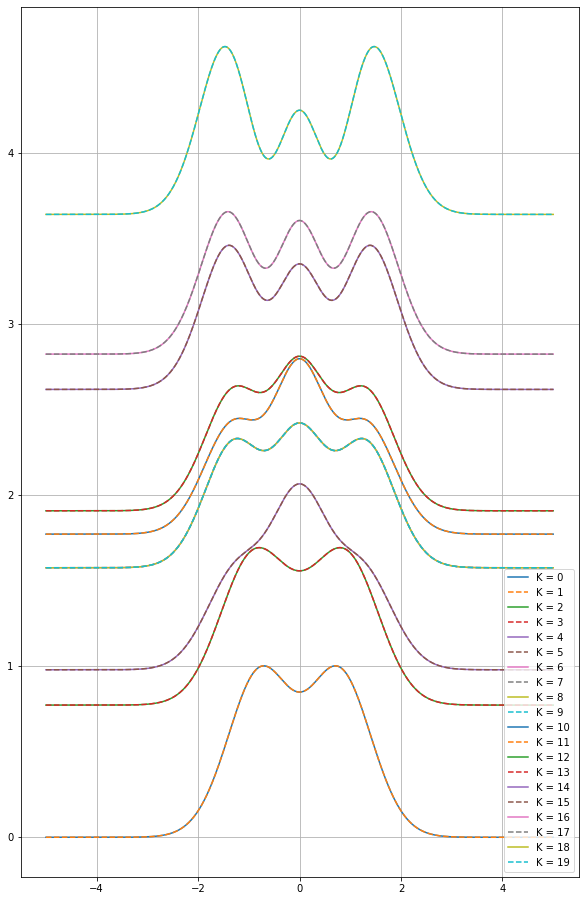

In [138]:
fig = plt.figure(figsize=(10, 16))

for I in range(min(cisdt.num_states, 20)):
    dip = cisdt.compute_one_body_expectation_value(system.dipole_moment[0], K=I)
    print(fr"E_{I} = {cisdt.energies[I]:.4f}  | <d_{I}> = {dip.real:.5f}")
    for J in range(I + 1, min(cisdt.num_states, 20)):
        print(f"\tDipole allowed {I} -> {J}: {cisdt.allowed_dipole_transition(I, J)}")
    rho_I = cisdt.compute_particle_density(K=I).real

    plt.plot(
        system.grid,
        rho_I + cisdt.energies[I].real - cisdt.energies[0].real,
        "-" if I % 2 == 0 else "--",
        label=fr"K = {I}",
    )
    print(f"\t(int) dx rho_{I}(x) = {np.trapz(rho_I, system.grid)}")

plt.grid()
plt.legend(loc="lower right")
plt.show()